# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%run ../../setup_project.py
%run ../../generic_plot_functions.py

import os.path
import shutil
from scipy.stats import wilcoxon, pearsonr


In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [3]:
for ses in sSessions:
    ses.load_parameters_from_files() 

# Functions

In [4]:
def plot_waveforms_neuronexus(mainSpec,clu_id):
    mouse=clu_id.split('-')[0]
    date=clu_id.split('-')[1]
    appendix=clu_id.split('_')[0].split('-')[2]
    name=f"{mouse}-{date}-{appendix}"
    path=f"/adata/electro/{mouse}/{name}/"
    clu=clu_id.split('_')[1]
    ses = Kilosort_session(name=name,path=path)
    ses.load_parameters_from_files()
    stl = Spike_train_loader()
    stl.load_spike_train_kilosort(ses)
    cg = Cell_group(stl)
    index = np.where([neuron.cluster_number == int(clu) for neuron in cg.neuron_list])[0][0]
    n = cg.neuron_list[index]
    df = Dat_file_reader(file_names=[f"{path}{mouse}-{date}_01.dat"], n_channels=65)
    sw = Spike_waveform(session=ses, dat_file_reader=df, spike_train=n.spike_train)
    sw.mean_waveform(block_size=200, channels=np.asarray([n for n in range(64)]), n_spikes=2000) #calculate the mean waveforms for all channels over a time interval of 200 ms (greater time intervals gave errors)
    upper_sites = [((n+1)*16-1) for n in range(4)] + [((n+1)*16-2) for n in range(4)]
    ch_map = np.load(f"{path}channel_map.npy")
    rows = np.tile(np.flip(range(9)), 4)
    rows = np.repeat(rows,2,axis=0)

    cols = (np.repeat([[1,0],[4,3],[7,6],[10,9]],9,axis=0))
    cols = cols.flatten()
    ax_map = [(row, col) for (row, col) in zip(rows, cols)]

    # get the n_channels channels with the highest amplitudes
    n_channels = 8
    amplitudes = [abs(max(sw.mean_waveforms[n,:])) + abs(min(sw.mean_waveforms[n,:])) for n in range(sw.mean_waveforms.shape[0])]
    channel_amp_list = [(c,a) for c,a in zip(amplitudes, range(sw.mean_waveforms.shape[0]))]
    channel_amp_dict = dict(channel_amp_list)
    amp_sorted_channels = [channel_amp_dict[a] for a in sorted(channel_amp_dict)]
    channels = amp_sorted_channels[:(sw.mean_waveforms.shape[0]-n_channels-1):-1]

    # plot the wave forms 
    layout = gridspec.GridSpecFromSubplotSpec(ncols=11, nrows=9, subplot_spec=mainSpec, width_ratios=[1,1,0.3,1,1,0.3,1,1,0.3,1,1])
    n_ax = 0
    titleSites = [15, 31, 47, 63]
    shankMap = {15:'Sh1',
                31:'Sh2',
                47:'Sh3',
                63:'Sh4'}
    for n in range(sw.mean_waveforms.shape[0]):
        if n in upper_sites:
            ax = fig.add_subplot(layout[ax_map[n_ax][0],(ax_map[n_ax][1]-1):(ax_map[n_ax][1])])
            n_ax += 2
            if n in titleSites:
                ax.set_title("      "+shankMap[n],fontsize=10)
        else:
            ax = fig.add_subplot(layout[ax_map[n_ax]])
            n_ax += 1
        if ch_map[n] in channels:
            ax.plot(sw.mean_waveforms[np.squeeze(ch_map[n]),:], 'm')
        else:
            ax.plot(sw.mean_waveforms[np.squeeze(ch_map[n]),:])    
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        #ax.set_ylabel(np.squeeze(ch_map[n]), rotation=0)
        ax.set_ylabel('')
        ax.yaxis.set_ticks([])
        ax.set_ylim(sw.mean_waveforms[:,:].min(), sw.mean_waveforms[:,:].max())
        ax.get_xaxis().set_visible(False)
    
    
from spikeA.Spike_waveform import Spike_waveform


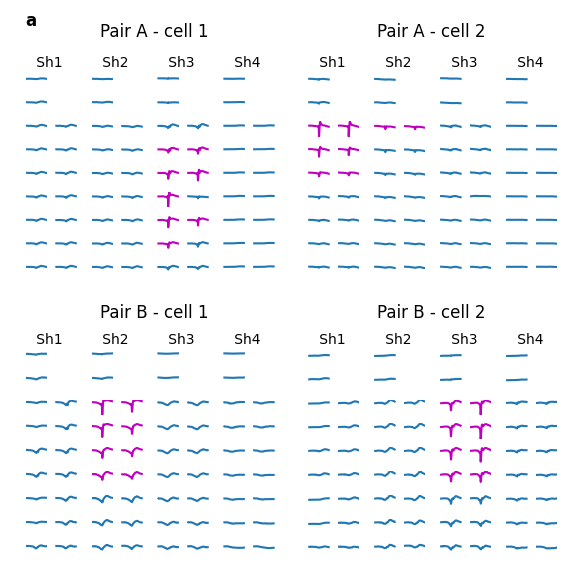

In [5]:
rowSize,colSize= figurePanelDefaultSize()
ncols=3
nrows=3
fig = plt.figure(figsize=(ncols*colSize, (nrows+0.1)*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=3, nrows=4, width_ratios=[1,0.1,1], height_ratios=[0.18,1,0.2,1]) # create a GridSpec object to a figure

plot_waveforms_neuronexus(clu_id='mn8578-23122021-0108_70', mainSpec=mainSpec[1,0])
plot_waveforms_neuronexus(clu_id='mn8578-23122021-0108_141', mainSpec=mainSpec[1,2])
plot_waveforms_neuronexus(clu_id='jp3120-25052022-0107_258', mainSpec=mainSpec[3,0])
plot_waveforms_neuronexus(clu_id='jp3120-25052022-0107_306', mainSpec=mainSpec[3,2])

ax = fig.add_subplot(mainSpec[:,:]) # add an axes to the figure
ax.text(0,0.97, 'a', style='normal',fontsize=12, weight="bold")
ax.text(0.14,0.95, 'Pair A - cell 1', style='normal',fontsize=12)
ax.text(0.66,0.95, 'Pair A - cell 2', style='normal',fontsize=12)
ax.text(0.14,0.44, 'Pair B - cell 1', style='normal',fontsize=12)
ax.text(0.66,0.44, 'Pair B - cell 2', style='normal',fontsize=12)

ax.axis("off")

plt.savefig('../../Output/Sup_Figure1.pdf', bbox_inches='tight', dpi=300)